In [49]:
'''
Here, we plot PDGrapher performance as a function of the PPI threshold
Chemical and genetic datasets, random split
'''

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os.path as osp
from glob import glob
import sys
sys.path.append('../../')
from constants import *
import os
import numpy as np
from scipy import stats


outdir = 'processed'
os.makedirs(outdir, exist_ok = True)
performance = {}

def add_to_performance(df, cell_line, method_name, performance):
    # Populate the dictionary
    for index, row in df.iterrows():
        metric = row['Metric']
        if metric == 'ranking score':
            metric = 'rankings'
        if metric == 'ranking score DCG':
            metric = 'nDCG'
        if cell_line not in performance:
            performance[cell_line] = {}
            
        if metric not in performance[cell_line]:
            performance[cell_line][metric] = {method_name: []}

        values = [row['Fold 1'], row['Fold 2'], row['Fold 3'], row['Fold 4'], row['Fold 5']]
        performance[cell_line][metric][method_name] = values
    return performance

In [50]:
performance = {}

cell_line = 'Chemical'

for th in ['01', '02', '03', '04', '05']:
    df = pd.read_csv('../../../results_metrics_aggregated_bme/sensitivity_ppi/v2/chemical/{}_drugpred_within_best.csv'.format(th))
    df = df[df['Set'] == 'Test']

    method_name = '{}.{}'.format(th[0], th[1])
    performance = add_to_performance(df, cell_line, method_name, performance)
    
cell_line = 'Genetic'

for th in ['01', '02', '03', '04', '05']:
    df = pd.read_csv('../../../results_metrics_aggregated_bme/sensitivity_ppi/v2/genetic/{}_drugpred_within_best.csv'.format(th))
    df = df[df['Set'] == 'Test']

    method_name = '{}.{}'.format(th[0], th[1])
    performance = add_to_performance(df, cell_line, method_name, performance)
    
    

In [51]:
dict_renaming = {'Genetic': 'Genetic-PPI-Breast-MCF7',
                 'Chemical': 'Chemical-PPI-Breast-MDAMB231'}

## Panel partially accurate predictions

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager
font_dirs = ['/home/gonzag46/.fonts']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42  # Output Type 42 (TrueType), editable in Illustrator



/tmp/ipykernel_3055999/966197731.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genetic_data['Cancer Type'] = genetic_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_3055999/966197731.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemical_data['Cancer Type'] = chemical_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_3055999/966197731.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


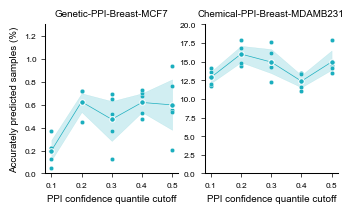

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the data for 'rankings' into a DataFrame
metric = 'percentage of samples with partially accurate predictions'
data = []
for cellline, metrics in performance.items():
    if metric in metrics:
        for method, values in metrics[metric].items():
            for value in values:
                data.append([cellline, method, value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

# Ensure Method is treated as a numeric value
df['Method'] = df['Method'].astype(float)

# Calculate the mean 'rankings' for each cell line and method
df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()

# Define a color palette that matches the existing figures
palette = {
    0.1: '#E2FAFA',
    0.2: '#B0F3F0',
    0.3: '#7DDCE0',
    0.4: '#4BC5CF',
    0.5: '#1AAEBE'
}



# Define the order of methods
method_order = ['0.1', '0.2', '0.3', '0.4', '0.5']

# Separate data into Genetic and Chemical categories
genetic_data = df[df['Cell Line'] == 'Genetic']
chemical_data = df[df['Cell Line'] == 'Chemical']

#Rename cell lines
genetic_data['Cancer Type'] = genetic_data['Cell Line'].map(dict_renaming)
chemical_data['Cancer Type'] = chemical_data['Cell Line'].map(dict_renaming)
# Replace x-axis labels with cancer types
genetic_data['Cell Line'] = genetic_data['Cancer Type']
chemical_data['Cell Line'] = chemical_data['Cancer Type']





with sns.plotting_context(plotting_context):
    # Initialize the plot with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3.543, 2.19), sharey=False)
    # Plot Genetic data
    if not genetic_data.empty:
        sns.lineplot(ax=ax1, data=genetic_data, x='Method', y=metric, color=palette[0.5], marker='o', markersize=4)
        sns.scatterplot(ax=ax1, data=genetic_data, x='Method', y=metric, color=palette[0.5], s=10, legend=False)
        ax1.set_xlabel('PPI confidence quantile cutoff')
        ax1.set_ylabel('Accurately predicted samples (%)')
        ax1.set_ylim(0, 1.3)
        ax1.tick_params(axis='both', which='major')
    # Plot Chemical data
    if not chemical_data.empty:
        sns.lineplot(ax=ax2, data=chemical_data, x='Method', y=metric, color=palette[0.5], marker='o', markersize=4)
        sns.scatterplot(ax=ax2, data=chemical_data, x='Method', y=metric, color=palette[0.5], s=10, legend=False)
        ax2.set_xlabel('PPI confidence quantile cutoff')
        ax2.set_ylabel('')
        ax2.set_ylim(0, 20)
        ax2.tick_params(axis='both', which='major')

    # Customize the legend
    handles, labels = ax2.get_legend_handles_labels()
    line_handles = handles[:len(method_order)]
    line_labels = labels[:len(method_order)]
    # legend = ax2.legend(line_handles, line_labels, bbox_to_anchor=(1.25, 1.15), loc='upper center', ncol=1, frameon=False, title='PPI confidence\nquantile cutoff')
    # legend.get_title().set_ha('center')
    # fig.supxlabel('PPI confidence quantile cutoff', fontsize = 12)  # Global X-axis title

    ax1.set_title(dict_renaming['Genetic'])  # X-axis title for Genetic
    ax2.set_title(dict_renaming['Chemical'])  # X-axis title for Chemical
    # ax1.set_xlabel('')  # X-axis title for Genetic
    # ax2.set_xlabel('')  # X-axis title for Genetic

    # Adjust layout
    plt.subplots_adjust(bottom=0.2, right=0.95)
    sns.despine()
    plt.savefig(osp.join(outdir, 'panel_partially_accurate_pred_lineplot.pdf'))
    plt.show()


## Panel nDCG

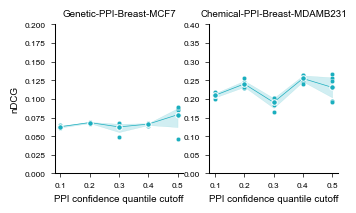

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the data for 'rankings' into a DataFrame
metric = 'nDCG'
data = []
for cellline, metrics in performance.items():
    if metric in metrics:
        for method, values in metrics[metric].items():
            for value in values:
                data.append([cellline, method, value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

# Ensure Method is treated as a numeric value
df['Method'] = df['Method'].astype(float)

# Calculate the mean 'rankings' for each cell line and method
df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()

# Define a color palette that matches the existing figures
palette = {
    0.1: '#E2FAFA',
    0.2: '#B0F3F0',
    0.3: '#7DDCE0',
    0.4: '#4BC5CF',
    0.5: '#1AAEBE'
}

# Separate data into Genetic and Chemical categories
genetic_data = df[df['Cell Line'] == 'Genetic']
chemical_data = df[df['Cell Line'] == 'Chemical']



with sns.plotting_context(plotting_context):
    # Initialize the plot with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3.543, 2.19), sharey=False)
    # Plot Genetic data
    if not genetic_data.empty:
        sns.lineplot(ax=ax1, data=genetic_data, x='Method', y=metric, color=palette[0.5], marker='o', markersize=4)
        sns.scatterplot(ax=ax1, data=genetic_data, x='Method', y=metric, color=palette[0.5], s=10, legend=False)
        ax1.set_xlabel('PPI confidence quantile cutoff')
        ax1.set_ylabel('nDCG')
        ax1.set_ylim(0, 0.2)
        ax1.tick_params(axis='both', which='major')
    # Plot Chemical data
    if not chemical_data.empty:
        sns.lineplot(ax=ax2, data=chemical_data, x='Method', y=metric, color=palette[0.5], marker='o', markersize=4)
        sns.scatterplot(ax=ax2, data=chemical_data, x='Method', y=metric, color=palette[0.5], s=10, legend=False)
        ax2.set_xlabel('PPI confidence quantile cutoff')
        ax2.set_ylabel('')
        ax2.set_ylim(0, 0.4)
        ax2.tick_params(axis='both', which='major')

    # Customize the legend
    handles, labels = ax2.get_legend_handles_labels()
    line_handles = handles[:len(method_order)]
    line_labels = labels[:len(method_order)]
    # fig.supxlabel('PPI confidence quantile cutoff', fontsize = 12)  # Global X-axis title
    ax1.set_title(dict_renaming['Genetic'])  # X-axis title for Genetic
    ax2.set_title(dict_renaming['Chemical'])  # X-axis title for Chemical
    # ax1.set_xlabel('')  # X-axis title for Genetic
    # ax2.set_xlabel('')  # X-axis title for Genetic

    # Adjust layout
    plt.subplots_adjust(bottom=0.2, right=0.95, left = 0.15)
    sns.despine()
    plt.savefig(osp.join(outdir, 'panel_ndcg_lineplot.pdf'))
    plt.show()


## Panels recall@k

/tmp/ipykernel_3055999/3872920616.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genetic_data['Cancer Type'] = genetic_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_3055999/3872920616.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemical_data['Cancer Type'] = chemical_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_3055999/3872920616.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

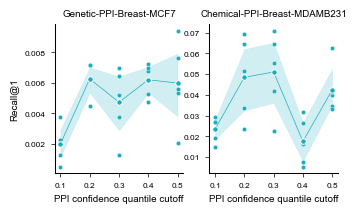

/tmp/ipykernel_3055999/3872920616.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genetic_data['Cancer Type'] = genetic_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_3055999/3872920616.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemical_data['Cancer Type'] = chemical_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_3055999/3872920616.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

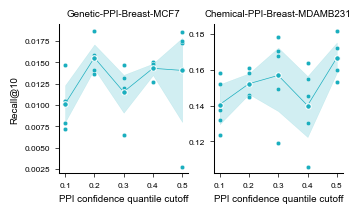

/tmp/ipykernel_3055999/3872920616.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genetic_data['Cancer Type'] = genetic_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_3055999/3872920616.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemical_data['Cancer Type'] = chemical_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_3055999/3872920616.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

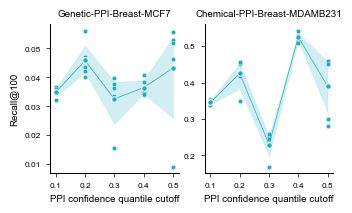

/tmp/ipykernel_3055999/3872920616.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genetic_data['Cancer Type'] = genetic_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_3055999/3872920616.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemical_data['Cancer Type'] = chemical_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_3055999/3872920616.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

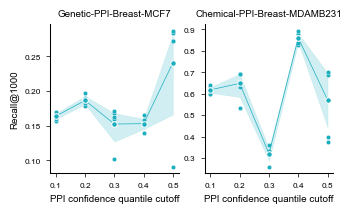

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the data for 'rankings' into a DataFrame
for metric in ['recall@1', 'recall@10', 'recall@100', 'recall@1000']:
    data = []
    for cellline, metrics in performance.items():
        if metric in metrics:
            for method, values in metrics[metric].items():
                for value in values:
                    data.append([cellline, method, value])

    # Create a DataFrame
    df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

    # Ensure Method is treated as a numeric value
    df['Method'] = df['Method'].astype(float)

    # Calculate the mean 'rankings' for each cell line and method
    df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()

    # Define a color palette that matches the existing figures
    palette = {
        0.1: '#E2FAFA',
        0.2: '#B0F3F0',
        0.3: '#7DDCE0',
        0.4: '#4BC5CF',
        0.5: '#1AAEBE'
    }

    # Separate data into Genetic and Chemical categories
    genetic_data = df[df['Cell Line'] == 'Genetic']
    chemical_data = df[df['Cell Line'] == 'Chemical']

    #Rename cell lines
    genetic_data['Cancer Type'] = genetic_data['Cell Line'].map(dict_renaming)
    chemical_data['Cancer Type'] = chemical_data['Cell Line'].map(dict_renaming)
    # Replace x-axis labels with cancer types
    genetic_data['Cell Line'] = genetic_data['Cancer Type']
    chemical_data['Cell Line'] = chemical_data['Cancer Type']




    with sns.plotting_context(plotting_context):
            # Initialize the plot with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3.543, 2.19), sharey=False)
        # Plot Genetic data
        if not genetic_data.empty:
            sns.lineplot(ax=ax1, data=genetic_data, x='Method', y=metric, color=palette[0.5], marker='o', markersize=4)
            sns.scatterplot(ax=ax1, data=genetic_data, x='Method', y=metric, color=palette[0.5], s=10, legend=False)
            ax1.set_xlabel('PPI confidence quantile cutoff')
            ax1.set_ylabel(metric.capitalize())
            ax1.tick_params(axis='both', which='major')
            # ax1.set_ylim(0, 0.15)
        # Plot Chemical data
        if not chemical_data.empty:
            sns.lineplot(ax=ax2, data=chemical_data, x='Method', y=metric, color=palette[0.5], marker='o', markersize=4)
            sns.scatterplot(ax=ax2, data=chemical_data, x='Method', y=metric, color=palette[0.5], s=10, legend=False)
            ax2.set_xlabel('PPI confidence quantile cutoff')
            ax2.set_ylabel('')
            ax2.tick_params(axis='both', which='major')
            # ax2.set_ylim(0, 0.1)

        # Customize the legend
        handles, labels = ax2.get_legend_handles_labels()
        line_handles = handles[:len(method_order)]
        line_labels = labels[:len(method_order)]
        # fig.supxlabel('PPI confidence quantile cutoff', fontsize = 12)  # Global X-axis title
        ax1.set_title(dict_renaming['Genetic'])  # X-axis title for Genetic
        ax2.set_title(dict_renaming['Chemical'])  # X-axis title for Chemical
        # ax1.set_xlabel('')  # X-axis title for Genetic
        # ax2.set_xlabel('')  # X-axis title for Genetic

        # Adjust layout
        plt.subplots_adjust(bottom=0.2, right=0.95, left = 0.15)
        sns.despine()
        plt.savefig(osp.join(outdir, 'panel_{}_lineplot.pdf'.format(metric)))
        plt.show()
